In [1]:
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile

def get_sin_oscillator(freq, amp=1, phase=0, sample_rate=44100):
    phase = (phase / 360) * 2 * math.pi
    
    increment = (2 * math.pi * freq)/ sample_rate
    
    return (math.sin(phase + v) * amp for v in itertools.count(start=0, step=increment))

## Функция

[0.984807753012208, 0.971994492787488, 0.9553625858539904, 0.9349773735044321, 0.9109189425341849, 0.8832818106065943, 0.8521745549241634, 0.8177193856644315, 0.7800516658563768, 0.7393193795835922]


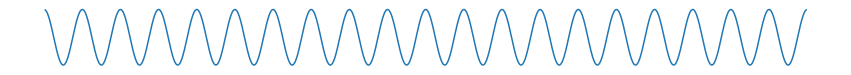

In [2]:
sample_rate = 44100
freq = 440


osc = get_sin_oscillator(freq, amp=1, phase=100)
samples = [next(osc) for i in range(sample_rate)]
print(samples[:10])
figure = plt.figure(figsize=(15, 20))
plt.subplot(15, 1, 1)
plt.axis('off')
plt.plot(samples[:2000])

Audio(samples, rate=sample_rate)



## Импорт

In [17]:
from abc import ABC, abstractmethod
import lib.osc
import lib.modulator
import lib.envelope
import lib.utils
import seaborn as sns


ModulatedOscillator = lib.modulator.ModulatedOscillator
Oscillator = lib.osc.Oscillator
ADSREnvelope = lib.envelope.ADSREnvelope
SR = 44_100

figsize=(25, 6.25)
colors = "#323031", "#308E91", "#34369D","#5E2A7E", "#5E2A7E", "#6F3384"



## Осцилятор

In [3]:
    
class SineOscillator(Oscillator):
    def _post_freq_set(self):
        
        self._step = (2 * math.pi * self._f) / self._sample_rate
        
    def _post_phase_set(self):
        self._p = (self._p / 360) * 2 * math.pi
        
    def _initialize_osc(self):
        self._i = 0
        
    def __next__(self):
        val = math.sin(self._i + self._p)
        self._i = self._i + self._step
        if self._wave_range is not (-1, 1):
            val = self.squish_val(val, *self._wave_range)
        return val * self._a
    

class SquareOscillator(Oscillator):
    
    def _post_freq_set(self):
        self._step = (2 * math.pi * self._f) / self._sample_rate
        
    def _post_phase_set(self):
        self._p = (self._p / 360) * 2 * math.pi
        
    def _initialize_osc(self):
        self._i = 0
        
        
    def __init__(self, freq=440, phase=0, amp=1, \
                 sample_rate=44_100, wave_range=(-1, 1), threshold=0):
        super().__init__(freq, phase, amp, sample_rate, wave_range)
        self.threshold = threshold
    
    def __next__(self):
        val = math.sin(self._i + self._p)
        self._i = self._i + self._step
        if val < self.threshold:
            val = self._wave_range[0]
        else:
            val = self._wave_range[1]
        return val * self._a
    
    
    
class SawtoothOscillator(Oscillator):
    def _post_freq_set(self):
        self._period = self._sample_rate / self._f
        self._post_phase_set
        
    def _post_phase_set(self):
        self._p = ((self._p + 90)/ 360) * self._period
    
    def _initialize_osc(self):
        self._i = 0
    
    def __next__(self):
        div = (self._i + self._p )/self._period
        val = 2 * (div - math.floor(0.5 + div))
        self._i = self._i + 1
        if self._wave_range is not (-1, 1):
            val = self.squish_val(val, *self._wave_range)
        return val * self._a

    
class WaveAdder:
    def __init__(self, *oscillators):
        self.oscillators = oscillators
        self.n = len(oscillators)
    
    def __iter__(self):
        [iter(osc) for osc in self.oscillators]
        return self
    
    def __next__(self):
        return sum(next(osc) for osc in self.oscillators) / self.n
    


    

<>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:68: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:68: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/6s/_31kgkdx7gd2mmz74zjgfdjm0000gn/T/ipykernel_8467/2411133339.py:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self._wave_range is not (-1, 1):
/var/folders/6s/_31kgkdx7gd2mmz74zjgfdjm0000gn/T/ipykernel_8467/2411133339.py:68: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self._wave_range is not (-1, 1):


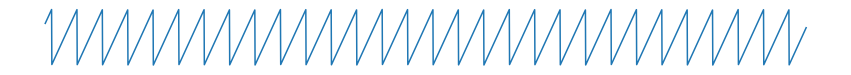

In [4]:
sample_rate =44100

gen1 = WaveAdder(
    SawtoothOscillator(freq=440,phase=0),
#     SineOscillator(freq=440,phase=100),
#     TriangleOscillator(freq=220, amp=0.8),
#     SawtoothOscillator(freq=400, amp=0.6),
#     SquareOscillator(freq=55, amp=0.4),
)
    
iter(gen1)
wav = [next(gen1) for _ in range(sample_rate * 4)] # 4 Seconds

figure = plt.figure(figsize=(15, 20))
plt.subplot(15, 1, 1)
plt.axis('off')
plt.plot(wav[:3000])

Audio(wav, rate=sample_rate)
# utils.wave_to_file(wav, fname="prelude_one.wav")

## Модулятор

##### Утилиты

In [19]:
import seaborn as sns
SR = 44_100

figsize=(25, 6.25)
colors = "#323031", "#308E91", "#34369D","#5E2A7E", "#5E2A7E", "#6F3384"


hz = lambda note:librosa.note_to_hz(note)
getfig = lambda : plt.figure(figsize=figsize)
savefig = lambda fig, name: fig.savefig(f"./tempimg/{name}.jpg")
to_16 = lambda wav, amp: np.int16(wav * amp * (2**15 - 1))

def plot(xy, r=1,c=1,i=1,title="", xlabel="",ylabel="",yticks=None, xticks=None,**plot_kwargs):
    # plt.plot helper
    if r > 0:
        plt.subplot(r,c,i)
    plt.title(title)
    if len(xy) == 2:
        plt.plot(*xy, **plot_kwargs)
    else:
        plt.plot(xy, **plot_kwargs)
        
    if xticks is not None: plt.xticks(xticks)
    if yticks is not None: plt.yticks(yticks)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    
def getval(osc, count=SR, it=False):
    if it: osc = iter(osc)
    # returns 1 sec of samples of given osc.
    return [next(osc) for i in range(count)]

def getseq(osc, notes=["C4", "E4", "G4"], note_lens=[0.5,0.5,0.5]):
    # Returns samples of the note seq for the given osc.
    samples = []
    osc = iter(osc)
    for note, note_len in zip(notes, note_lens):
        osc.freq = librosa.note_to_hz(note)
        for _ in range(int(SR * note_len)):
            samples.append(next(osc))
    return samples

def wave_to_file(wav, wav2=None, fname="temp", amp=0.1):
    wav = np.array(wav)
    wav = to_16(wav, amp)
    if wav2 is not None:
        wav2 = np.array(wav2)
        wav2 = to_16(wav2, amp)
        wav = np.stack([wav, wav2]).T
    
    wavfile.write(f"tempsnd/{fname}.wav", SR, wav)
    
def fplot_xy(wave, fslice=slice(0,100), sample_rate=SR):
    # Returns FFTed samples of input wave
    fd = np.fft.fft(wave)
    fd_mag = np.abs(fd)
    x = np.linspace(0, sample_rate, len(wave))
    y = fd_mag * 2 / sample_rate
    return x[fslice], y[fslice]


def gettrig(gen, downtime, sample_rate=SR):
    gen = iter(gen)
    down = int(downtime * sample_rate)
    vals = getval(gen, down)
    gen.trigger_release()
    while not gen.ended:
        vals.append(next(gen))
    return vals

##### Компоненты

In [34]:
class Panner:
    def __init__(self, r=0.5):
        self.r = r
        
    def __call__(self, val):
        r = self.r * 2
        l = 2 - r
        return (l * val, r * val)
    
    
class Chain:
    def __init__(self, generator, *modifiers):
        self.generator = generator
        self.modifiers = modifiers
        
    def __getattr__(self, attr):
        val = None
        if hasattr(self.generator, attr):
            val = getattr(self.generator, attr)
        else:
            for modifier in self.modifiers:
                if hasattr(modifier, attr):
                    val = getattr(modifier, attr)
                    break
            else:
                raise AttributeError(f"attribute '{attr}' does not exist")
        return val
    
    def trigger_release(self):
        tr = "trigger_release"
        if hasattr(self.generator, tr):
            self.generator.trigger_release()
        for modifier in self.modifiers:
            if hasattr(modifier, tr):
                modifier.trigger_release()
                
    @property
    def ended(self):
        ended = []; e = "ended"
        if hasattr(self.generator, e):
            ended.append(self.generator.ended)
        ended.extend([m.ended for m in self.modifiers if hasattr(m, e)])
        return all(ended)
    
    def __iter__(self):
        iter(self.generator)
        [iter(mod) for mod in self.modifiers if hasattr(mod, "__iter__")]
        return self
        
    def __next__(self):
        val = next(self.generator)
        [next(mod) for mod in self.modifiers if hasattr(mod, "__iter__")]
        for modifier in self.modifiers:
            val = modifier(val)
        return val
    
    
from collections.abc import Iterable

class WaveAdder:
    def __init__(self, *generators, stereo=False):
        self.generators = generators
        self.stereo = stereo
        
    def _mod_channels(self, _val):
        val = _val
        if isinstance(_val, (int, float)) and self.stereo:
            val = (_val, _val)
        elif isinstance(_val, Iterable) and not self.stereo:
            val = sum(_val)/len(_val)
        return val
    
    def trigger_release(self):
        [gen.trigger_release() for gen in self.generators if hasattr(gen, "trigger_release")]
    
    @property
    def ended(self):
        ended = [gen.ended for gen in self.generators if hasattr(gen, "ended")]
        return all(ended)
    
    def __iter__(self):
        [iter(gen) for gen in self.generators]
        return self
            
    def __next__(self):
        vals = [self._mod_channels(next(gen)) for gen in self.generators]
        if self.stereo:
            l, r = zip(*vals)
            val = (sum(l)/len(l), sum(r)/len(r))
        else:
            val = sum(vals)/ len(vals)
        return val

##### Запуск

In [82]:



def amp_mod(init_amp, env):
    return env * init_amp
    
def freq_mod(init_freq, env, mod_amt=0.01, sustain_level=0.7):
    return init_freq + ((env - sustain_level) * init_freq * mod_amt)



def getadsr(a, d, sl, sd, r, Osc=SquareOscillator(55), mod = None):
    if mod is None:
        mod = ModulatedOscillator(
            Osc,
            ADSREnvelope(a,d,sl,r),
            amp_mod=amp_mod
        )
    downtime = a + d + sd
    return gettrig(mod, downtime)


##### Запуск 2

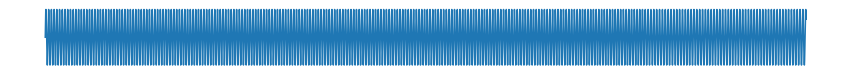

In [149]:
def freq_mod(init_freq, env, mod_amt=0.01, sustain_level=0.7):
#     print(env)
    return init_freq * env 


gen = WaveAdder(
    
    
    ModulatedOscillator(
        SineOscillator(freq=440),
        SquareOscillator(freq=1, wave_range=(0.95, 1)),
        freq_mod=freq_mod,
    ),
    
    stereo=False
)

wav = getval(iter(gen), int(SR*4))


figure = plt.figure(figsize=(15, 20))
plt.subplot(15, 1, 1)
plt.axis('off')
plt.plot(wav[:28000])
Audio(wav, rate=44100)